### Install

In [3]:
pip install tensorflow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


### Import Libery

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

### GPU Check

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


### Data Transform

In [8]:
IMAGE_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Create Data

In [9]:
dataset_path = "/kaggle/input/animals10/raw-img"
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

In [10]:
print("Total images:", len(full_dataset))
print("Class names:", full_dataset.classes)

Total images: 26179
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


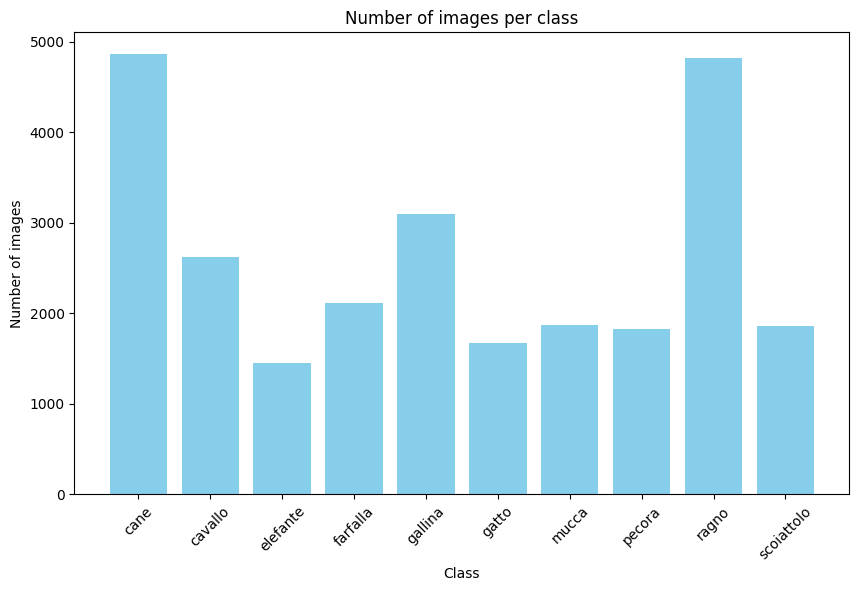

In [13]:
class_indices = [s[1] for s in full_dataset.samples]

counts = Counter(class_indices)

class_counts = [counts[i] for i in range(len(full_dataset.classes))]

plt.figure(figsize=(10, 6))
plt.bar(full_dataset.classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per class')
plt.xticks(rotation=45)
plt.show()

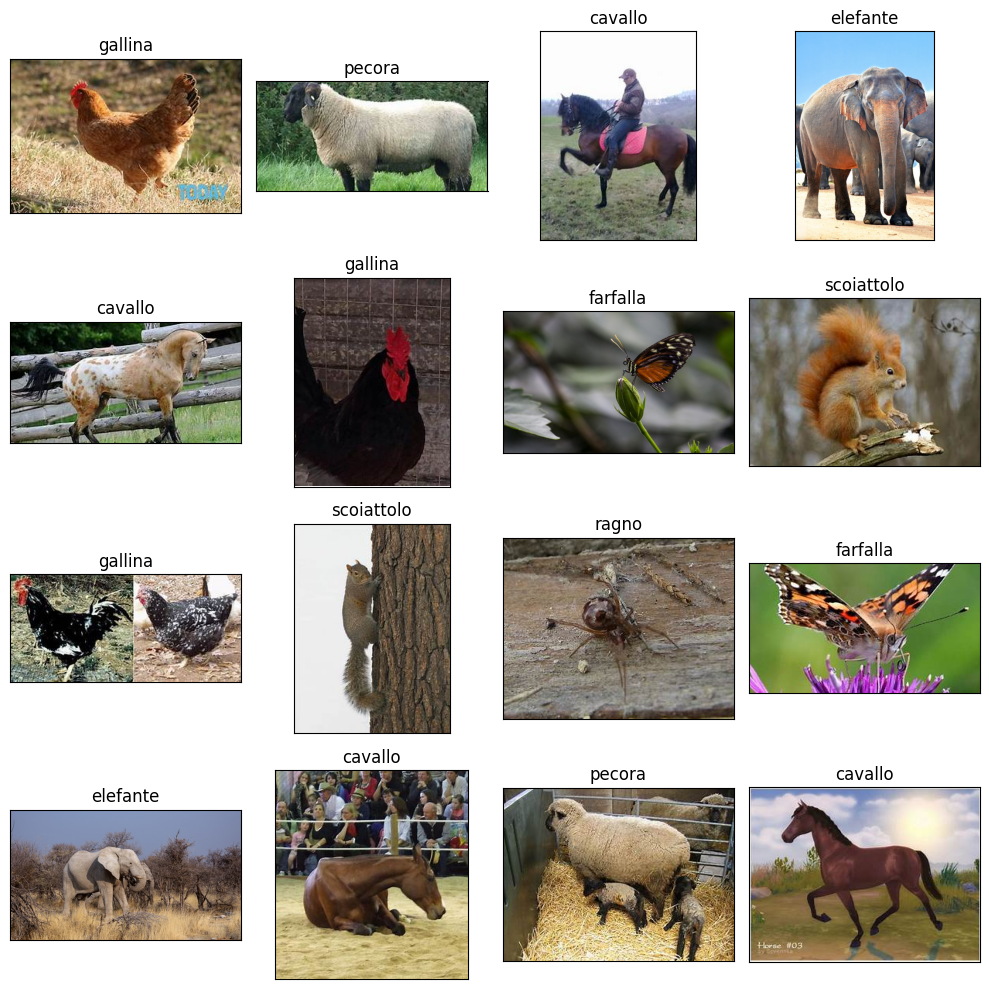

In [20]:
random_index = np.random.randint(0, len(full_dataset), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    filepath, label_idx = full_dataset.samples[random_index[i]]
    image = plt.imread(filepath)
    ax.imshow(image)
    ax.set_title(full_dataset.classes[label_idx])
    
plt.tight_layout()
plt.show()

### Split Data

In [16]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))

Train dataset size: 20943
Val dataset size: 5236


### Create DataLoader

In [17]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Create Model

In [21]:
model = torchvision.models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


### Lost Function

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reduce ir
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True)

# Set Early Stopping and Best Model Saving
patience = 3
patience_counter = 0
best_val_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# metric for plot
train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Train One Epoch Function

In [23]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

### Evaluate Function (Loss, Accuracy and F1 Score)

In [24]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_acc, epoch_f1

### Model Train

In [25]:
NUM_EPOCHS = 30


for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    # Improve learning rate form validation F1 score
    scheduler.step(val_f1)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

    # Best Model Save (validation F1 score)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("  Best model saved.")
        patience_counter = 0  # reset counter
    else:
        patience_counter += 1

    # not improve epoch stop train
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Load Best Model
model.load_state_dict(best_model_wts)

Epoch [1/30]
  Train Loss: 0.9721 | Train Acc: 67.86%
  Val Loss: 0.9887 | Val Acc: 69.14% | Val F1: 0.6922
  Best model saved.
Epoch [2/30]
  Train Loss: 0.5936 | Train Acc: 80.65%
  Val Loss: 0.7076 | Val Acc: 77.50% | Val F1: 0.7778
  Best model saved.
Epoch [3/30]
  Train Loss: 0.4649 | Train Acc: 84.73%
  Val Loss: 0.4684 | Val Acc: 85.01% | Val F1: 0.8502
  Best model saved.
Epoch [4/30]
  Train Loss: 0.3960 | Train Acc: 87.16%
  Val Loss: 0.5150 | Val Acc: 83.35% | Val F1: 0.8368
Epoch [5/30]
  Train Loss: 0.3502 | Train Acc: 88.60%
  Val Loss: 0.4649 | Val Acc: 84.84% | Val F1: 0.8500
Epoch [6/30]
  Train Loss: 0.3144 | Train Acc: 89.86%
  Val Loss: 0.4652 | Val Acc: 85.58% | Val F1: 0.8528
  Best model saved.
Epoch [7/30]
  Train Loss: 0.2792 | Train Acc: 90.93%
  Val Loss: 0.3761 | Val Acc: 88.29% | Val F1: 0.8822
  Best model saved.
Epoch [8/30]
  Train Loss: 0.2618 | Train Acc: 91.44%
  Val Loss: 0.5462 | Val Acc: 83.52% | Val F1: 0.8404
Epoch [9/30]
  Train Loss: 0.2360 | 

<All keys matched successfully>

### Graph

In [27]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(18,5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

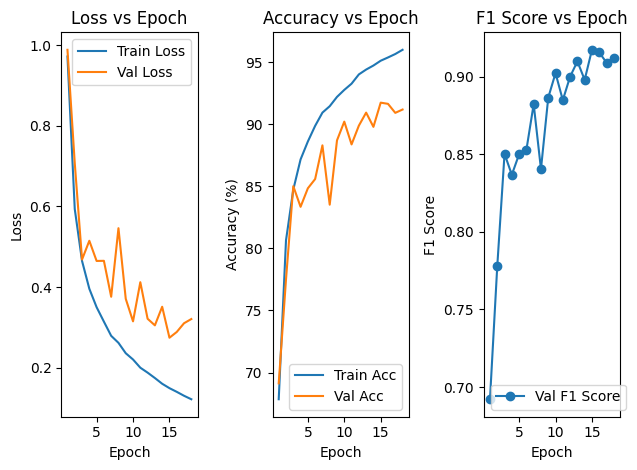

In [30]:
plt.subplot(1,3,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs_range, val_f1s, label="Val F1 Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

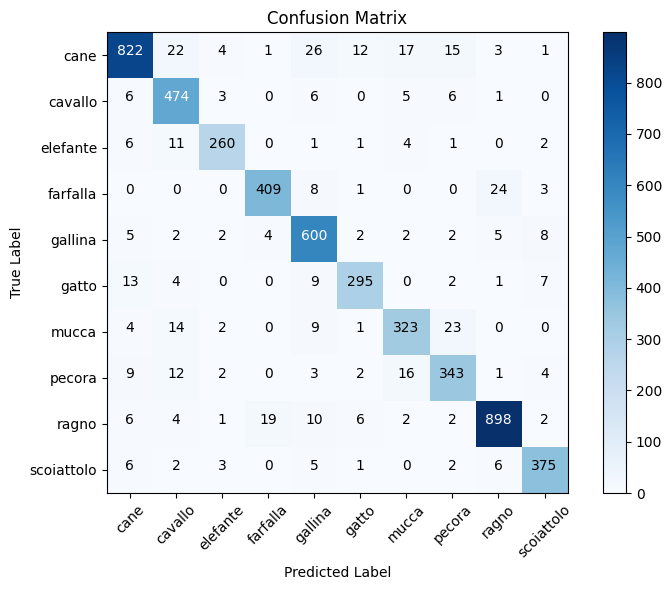

In [31]:
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

classes = full_dataset.classes

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Predicted Validation

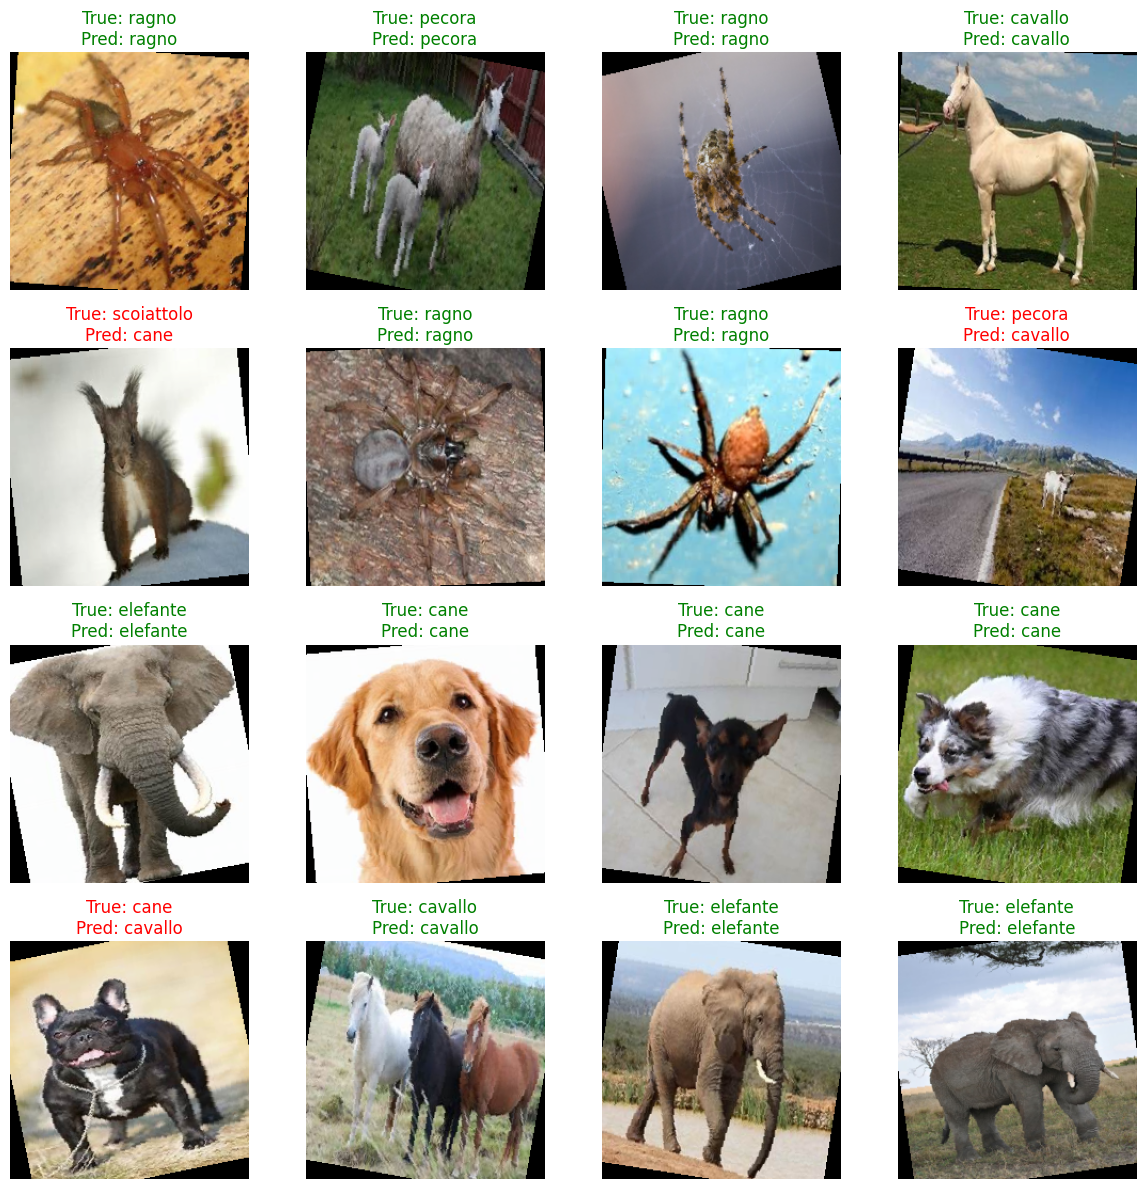

In [34]:
num_samples = 16
indices = np.random.choice(len(val_dataset), size=num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, idx in enumerate(indices):
    image, label = val_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    pred = pred.item()
    
    # Inverse normalization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    ax = axes.flat[i]
    ax.imshow(image_np)
    
    color = 'green' if pred == label else 'red'
    
    true_label = val_dataset.dataset.classes[label]
    pred_label = val_dataset.dataset.classes[pred]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

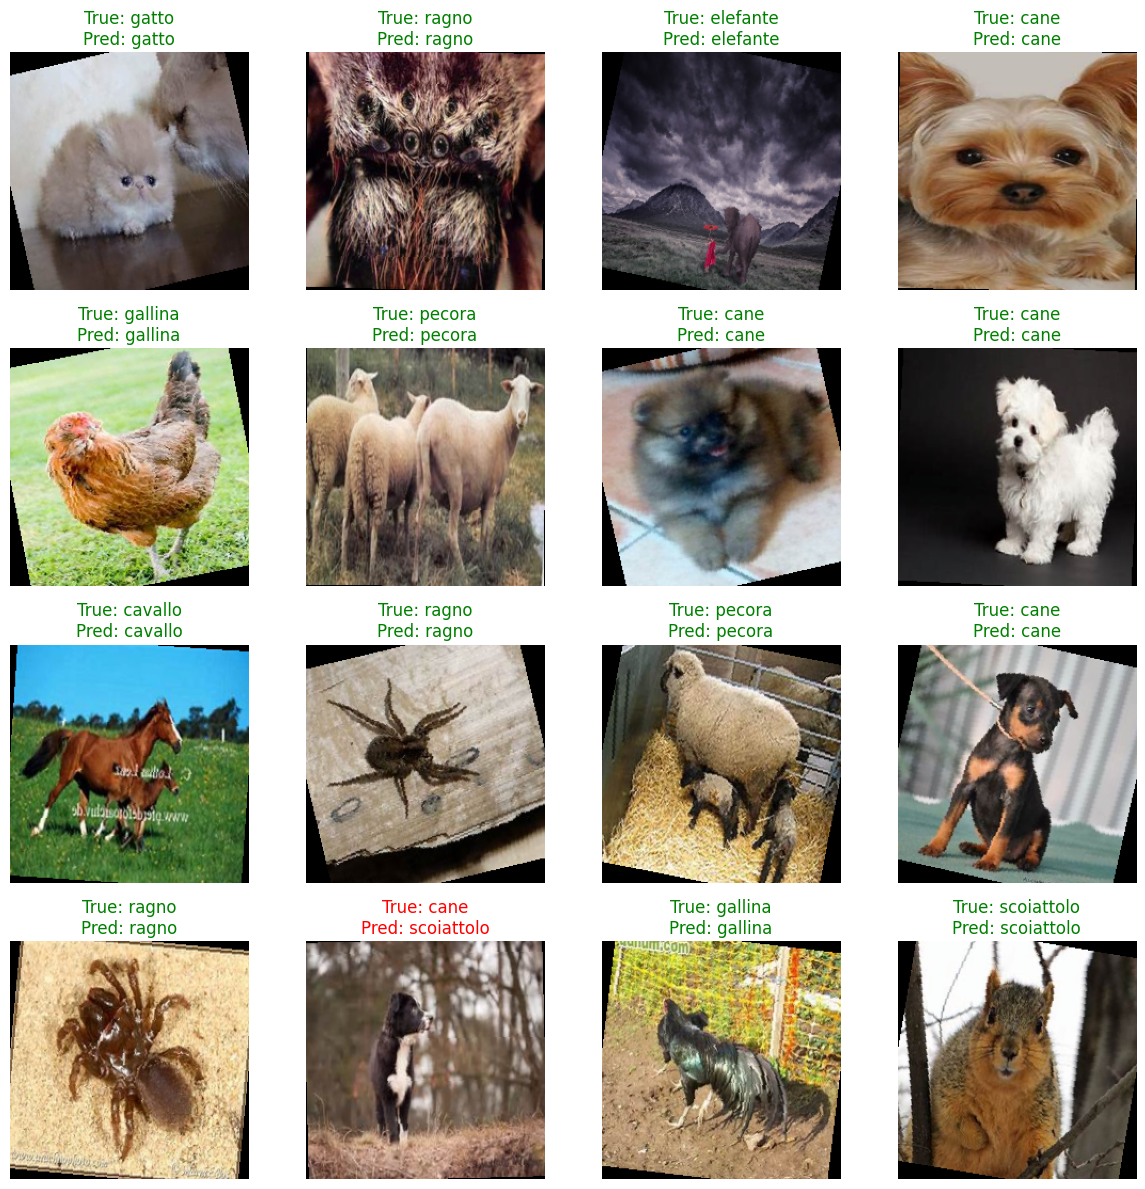

In [35]:
num_samples = 16
indices = np.random.choice(len(val_dataset), size=num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, idx in enumerate(indices):
    image, label = val_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    pred = pred.item()
    
    # Inverse normalization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    ax = axes.flat[i]
    ax.imshow(image_np)
    
    color = 'green' if pred == label else 'red'
    
    true_label = val_dataset.dataset.classes[label]
    pred_label = val_dataset.dataset.classes[pred]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()